<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_25_Bert_text_classification/notebooks/Day_25_bert_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT for Text Classification
## Day 25/30 of Machine Learning Project

**Project Goal**: Fine-tune BERT for sentiment classification using the IMDB movie reviews dataset.

## 1. Import Required Libraries

In [ ]:
!pip install transformers datasets evaluate accelerate -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import DataLoader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00


In [ ]:
from torch.optim import AdamW
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer
)

In [ ]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


## 2. Load and Prepare the Dataset

We'll use the IMDB movie reviews dataset for sentiment analysis (positive/negative).

In [ ]:
!pip install tensorflow-datasets

import tensorflow_datasets as tfds
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load IMDB dataset from TFDS
ds = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)
train_ds, test_ds = ds[0], ds[1]

# Convert to pandas DataFrames
train_df = pd.DataFrame([(text.numpy().decode('utf-8'), label.numpy())
                        for text, label in train_ds],
                       columns=['text', 'label'])
test_df = pd.DataFrame([(text.numpy().decode('utf-8'), label.numpy())
                       for text, label in test_ds],
                      columns=['text', 'label'])

# Create smaller subsets for faster training
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.iloc[:5000]

test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.iloc[:1000]

# Split train into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Convert back to Hugging Face Dataset
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
test_data = Dataset.from_pandas(test_df)

# Inspect the dataset
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")
print("\nSample review:")
print(train_data[0]['text'])
print(f"Label: {'Positive' if train_data[0]['label'] == 1 else 'Negative'}")

Train size: 4500
Validation size: 500
Test size: 1000

Sample review:
"Hatred of a Minute" is a hauntingly beautiful film. A psychological thriller that takes you on a journey through the nightmare that is the life of a serial killer, Eric Seaver. Strong performances and excellent cinematography make this film a "must see" for any film student or horror fan. The realness of the story and the human side of Eric separate this film from other psycho killer movies. Some shout outs to the film's producer, Bruce Campbell as well as to the film "The Evil Dead" add some humor for anyone that knows the genre.
Label: Positive


## 3. Initialize BERT Tokenizer

In [ ]:
# Load BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

# Tokenize datasets
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Set format for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Tokenization complete.")

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization complete.


## 4. Create DataLoaders

In [ ]:
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_batch(batch):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]

    tokenized = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    tokenized['label'] = torch.tensor(labels)
    return tokenized

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=tokenize_batch)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=tokenize_batch)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=tokenize_batch)

batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("Input IDs shape:", batch['input_ids'].shape)
print("Attention mask shape:", batch['attention_mask'].shape)
print("Labels shape:", batch['label'].shape)


Batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
Input IDs shape: torch.Size([16, 256])
Attention mask shape: torch.Size([16, 256])
Labels shape: torch.Size([16])


## 5. Initialize BERT Model

In [ ]:
# Load BERT model for sequence classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

print(f"Model loaded on {device}")
print(model.config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda
BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## 6. Set Up Training Configuration

In [ ]:
# Training parameters
epochs = 3
learning_rate = 2e-5

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## 7. Training Loop

In [ ]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training and validation
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0

    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        total_val_loss += loss.item()
        total_val_accuracy += flat_accuracy(logits.cpu().numpy(), labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print(f"Val Accuracy: {avg_val_accuracy:.4f}\n")

Epoch 1/3
Train Loss: 0.3545
Val Loss: 0.2274
Val Accuracy: 0.9102

Epoch 2/3
Train Loss: 0.1458
Val Loss: 0.2884
Val Accuracy: 0.8926

Epoch 3/3
Train Loss: 0.0590
Val Loss: 0.2998
Val Accuracy: 0.8965



## 8. Plot Training Metrics

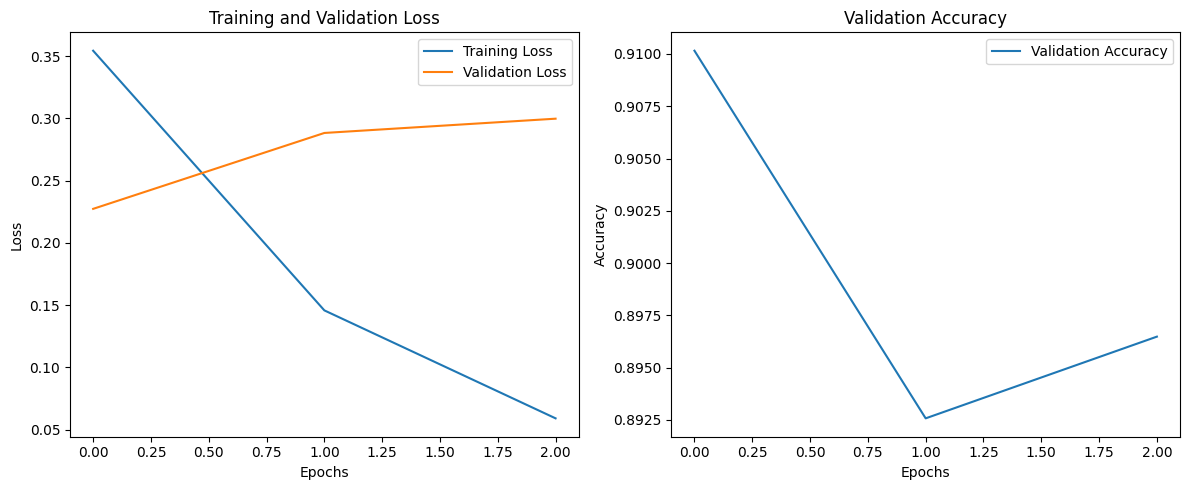

In [ ]:
# Plot training history
def plot_training_history(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(train_losses, val_losses, val_accuracies)

## 9. Evaluate on Test Set

Test Accuracy: 0.9140
Test F1 Score: 0.9157


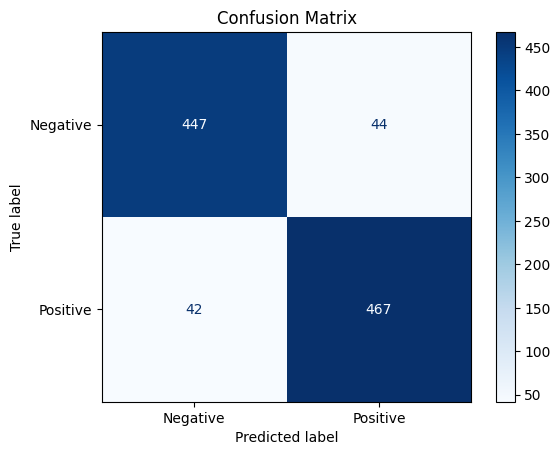

In [ ]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

## 10. Make Predictions on Sample Text

In [ ]:
# Prediction function
def predict_sentiment(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    ).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1).item()

    sentiment = 'Positive' if pred_label == 1 else 'Negative'
    confidence = probs[0][pred_label].item()

    print(f"Text: {text}")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.4f})")
    print(f"Probabilities: Negative: {probs[0][0].item():.4f}, Positive: {probs[0][1].item():.4f}")
    print("-" * 50)

# Sample predictions
sample_texts = [
    "This movie was absolutely fantastic! The acting was superb and the story was captivating.",
    "I've never been more disappointed in a film. The plot made no sense and the acting was terrible.",
    "The cinematography was beautiful, but the characters were poorly developed and the dialogue felt forced.",
    "A perfect blend of action, comedy, and drama. Highly recommend to everyone!"
]

for text in sample_texts:
    predict_sentiment(text)

Text: This movie was absolutely fantastic! The acting was superb and the story was captivating.
Sentiment: Positive (Confidence: 0.9962)
Probabilities: Negative: 0.0038, Positive: 0.9962
--------------------------------------------------
Text: I've never been more disappointed in a film. The plot made no sense and the acting was terrible.
Sentiment: Negative (Confidence: 0.9925)
Probabilities: Negative: 0.9925, Positive: 0.0075
--------------------------------------------------
Text: The cinematography was beautiful, but the characters were poorly developed and the dialogue felt forced.
Sentiment: Negative (Confidence: 0.8972)
Probabilities: Negative: 0.8972, Positive: 0.1028
--------------------------------------------------
Text: A perfect blend of action, comedy, and drama. Highly recommend to everyone!
Sentiment: Positive (Confidence: 0.9958)
Probabilities: Negative: 0.0042, Positive: 0.9958
--------------------------------------------------


## 11. Save and Load the Model

In [ ]:
# Save model
model.save_pretrained("bert_imdb_sentiment")
tokenizer.save_pretrained("bert_imdb_sentiment")
print("Model saved.")

# Load model
# loaded_model = BertForSequenceClassification.from_pretrained("bert_imdb_sentiment")
# loaded_tokenizer = BertTokenizerFast.from_pretrained("bert_imdb_sentiment")

Model saved.


## 12. Conclusion and Next Steps

**Key Insights**:
- BERT provides powerful contextual representations for text
- Fine-tuning on specific tasks yields excellent performance
- Transfer learning significantly reduces training time and data requirements

**Potential Improvements**:
1. Try different BERT variants (distilbert, roberta, albert)
2. Experiment with different hyperparameters (learning rate, batch size, sequence length)
3. Use full dataset for training
4. Apply to other text classification tasks (topic classification, spam detection)
5. Implement more advanced training techniques (learning rate scheduling, mixed precision)

**Real-world Applications**:
- Customer feedback analysis
- Social media sentiment monitoring
- News categorization
- Toxic comment detection
- Intent classification for chatbots